In [1]:
%load_ext autoreload
%autoreload 2

from nnTrain import train_efn, train_pfn, arch_scan, get_data, get_vars, get_constit_vars
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
from energyflow.utils import data_split, to_categorical
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_auc_score, roc_curve
import os
import glob
from tqdm.notebook import tqdm

# define rng seeds for train/test/val split for replicable results
rng1 = 45446
rng2 = 25135
rng3 = 34530
rng4 = 20461

2023-07-10 18:01:55.417487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Quark jets, R = 0.8

In [2]:
vars = ['E','eta','phi']

hdata = get_constit_vars('q',vars,hlevel=True,efrac=False)[:100000]
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_constit_vars('q',vars,hlevel=False,efrac=False)[:100000]
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng3)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng4)

del hdata, pdata, htrain, hval, ptrain, pval

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

del perm

In [21]:
# Evaluate mean/std of AUCs for spectral and non-spectral EFNs
efns = glob.glob("keras_models/qjet_EFN_zpT_iter*.keras")
spectral_efns = glob.glob("keras_models/qjet_spectralEFN_zpT_iter*.keras")

efn_aucs = []
for efname in efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=1000)
    auc = roc_auc_score(test_labels, preds)
    efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = []
for efname in spectral_efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=1000)
    auc = roc_auc_score(test_labels, preds)
    spectral_efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = [a if a>=0.5 else 1-a for a in spectral_efn_aucs]

50/50 [==============================] - 1s 10ms/step


In [23]:
print(f"EFN : AUC = {np.mean(efn_aucs):.4f} +/- {np.std(efn_aucs):.4f}")
print(f"Spectral EFN : AUC = {np.mean(spectral_efn_aucs):.4f} +/- {np.std(spectral_efn_aucs):.4f}")

EFN : AUC = 0.9631 +/- 0.0066
Spectral EFN : AUC = 0.5225 +/- 0.0160


In [16]:
from energyflow.emd import emd_wasserstein, emds_wasserstein
htest_trim = [h[h[:,0]>0] for h in htest]
ptest_trim = [p[p[:,0]>0] for p in ptest]

emds = []
for h,p in tqdm(zip(htest_trim,ptest_trim)):
    emds.append(emd_wasserstein(h,p,R=0.8,norm=False))
    
#spectral_efns = glob.glob("keras_models/qjet_spectralEFN_zpT_iter*.keras")
#delta_efns = []
#for efname in spectral_efns:
#    efn = keras.models.load_model(efname)
#    h_preds = efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=1000)
#    p_preds = efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=1000)
#    delta_efns.append((h_preds-p_preds))
#    del efn
#    del h_preds, p_preds
#    gc.collect()
#delta_efns = np.mean(np.concatenate(delta_efns,axis=1),axis=1)
z_h = htest[:,:,0]
theta_h = np.linalg.norm(htest[:,:,1:],axis=-1)
angularity_h = np.sum(theta_h*z_h,axis=1)

z_p = ptest[:,:,0]
theta_p = np.linalg.norm(ptest[:,:,1:],axis=-1)
angularity_p = np.sum(theta_p*z_p,axis=1)

0it [00:00, ?it/s]

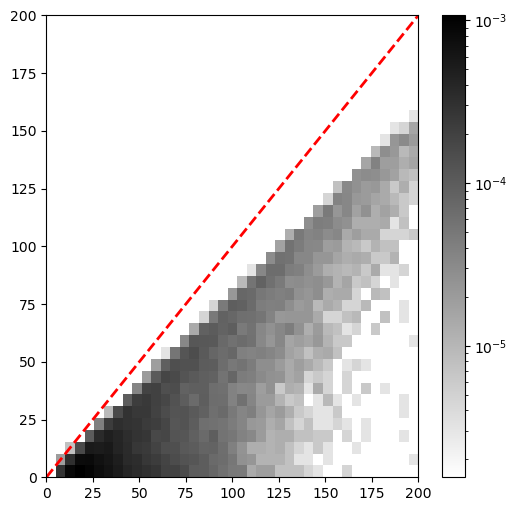

In [32]:
plt.figure(figsize=(6,6))
x = np.linspace(0,200,40)
from matplotlib.colors import LogNorm
h2 = plt.hist2d(emds,np.abs(angularity_h-angularity_p),bins=(x,x),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.plot(x,x,linestyle='--',color='red',linewidth=2)

# Gluon jets, R = 0.8

In [2]:
vars = ['z','eta','phi']

hdata = get_constit_vars('g',vars,hlevel=True,efrac=False)[:100000]
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_constit_vars('g',vars,hlevel=False,efrac=False)[:100000]
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng3)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng4)

del hdata, pdata, htrain, hval, ptrain, pval

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

del perm

In [3]:
# Evaluate mean/std of AUCs for spectral and non-spectral EFNs
efns = glob.glob("keras_models/gjet_EFN_zpT_iter*.keras")
spectral_efns = glob.glob("keras_models/gjet_spectralEFN_zpT_iter*.keras")

efn_aucs = []
htest_efn_scores = []
ptest_efn_scores = []
for efname in efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=10000)
    htest_efn_scores.append(efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=10000))
    ptest_efn_scores.append(efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=10000))
    auc = roc_auc_score(test_labels, preds)
    efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

sigmoid = keras.activations.sigmoid
spectral_efn_aucs = []
htest_spectral_efn_scores = []
ptest_spectral_efn_scores = []
for efname in spectral_efns:
    efn = keras.models.load_model(efname)
    preds = sigmoid(efn.predict([test[:,:,0],test[:,:,1:]],batch_size=10000))
    htest_spectral_efn_scores.append(efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=10000))
    ptest_spectral_efn_scores.append(efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=10000))
    auc = roc_auc_score(test_labels, preds)
    spectral_efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = [a if a>=0.5 else 1-a for a in spectral_efn_aucs]

2023-07-10 18:02:28.920899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 18:02:29.591819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 18:02:29.592196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 18:02:29.685299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

1/5 [=====>........................] - ETA: 7s

2023-07-10 18:02:33.880741: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 0s 74ms/step


In [4]:
print(f"EFN : AUC = {np.mean(efn_aucs):.4f} +/- {np.std(efn_aucs):.4f}")
print(f"Spectral EFN : AUC = {np.mean(spectral_efn_aucs):.4f} +/- {np.std(spectral_efn_aucs):.4f}")

EFN : AUC = 0.9604 +/- 0.0096
Spectral EFN : AUC = 0.5183 +/- 0.0022


In [5]:
from energyflow.emd import emd_wasserstein, emds_wasserstein
htest_trim = [h[h[:,0]>0] for h in htest]
ptest_trim = [p[p[:,0]>0] for p in ptest]

emds = []
for h,p in tqdm(zip(htest_trim,ptest_trim)):
    emds.append(emd_wasserstein(h,p,R=0.8,norm=False))
    
#spectral_efns = glob.glob("keras_models/qjet_spectralEFN_zpT_iter*.keras")
#delta_efns = []
#for efname in spectral_efns:
#    efn = keras.models.load_model(efname)
#    h_preds = efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=1000)
#    p_preds = efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=1000)
#    delta_efns.append((h_preds-p_preds))
#    del efn
#    del h_preds, p_preds
#    gc.collect()
#delta_efns = np.mean(np.concatenate(delta_efns,axis=1),axis=1)
z_h = htest[:,:,0]
theta_h = np.linalg.norm(htest[:,:,2:],axis=-1)
angularity_h = np.sum(theta_h*z_h,axis=1)

z_p = ptest[:,:,0]
theta_p = np.linalg.norm(ptest[:,:,2:],axis=-1)
angularity_p = np.sum(theta_p*z_p,axis=1)

0it [00:00, ?it/s]

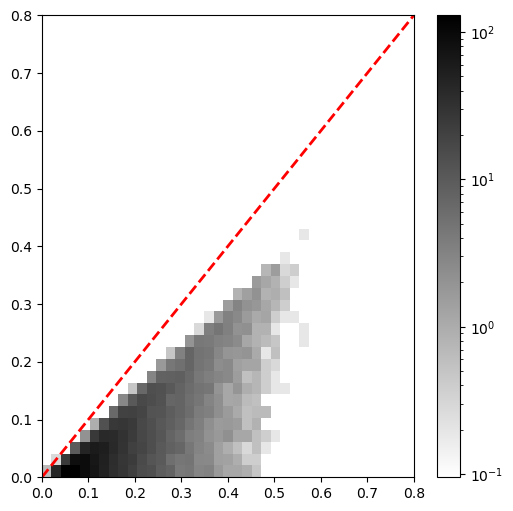

In [8]:
plt.figure(figsize=(6,6))
x = np.linspace(0,0.8,40)
from matplotlib.colors import LogNorm
h2 = plt.hist2d(emds,np.abs(angularity_h-angularity_p),bins=(x,x),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.plot(x,x,linestyle='--',color='red',linewidth=2)

In [9]:
htest_efn_scores = np.mean(np.concatenate(htest_efn_scores,axis=1),axis=1)
ptest_efn_scores = np.mean(np.concatenate(ptest_efn_scores,axis=1),axis=1)
htest_spectral_efn_scores = np.mean(np.concatenate(htest_spectral_efn_scores,axis=1),axis=1)
ptest_spectral_efn_scores = np.mean(np.concatenate(ptest_spectral_efn_scores,axis=1),axis=1)

In [24]:
def logit(x):
    return np.log(x/(1-x))
delta_efn = np.abs(logit(htest_efn_scores)-logit(ptest_efn_scores))
delta_spectral_efn = np.abs(htest_spectral_efn_scores-ptest_spectral_efn_scores)

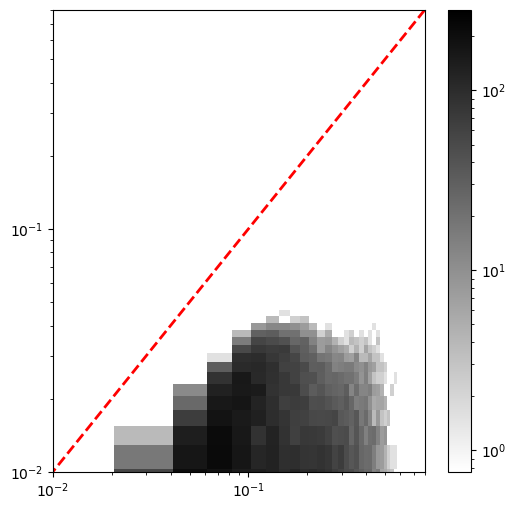

In [27]:
plt.figure(figsize=(6,6))
x = np.linspace(0,0.8,40)
y = np.linspace(0,0.1,40)
from matplotlib.colors import LogNorm
h2 = plt.hist2d(emds,delta_spectral_efn,bins=(x,y),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.plot(x,x,linestyle='--',color='red',linewidth=2)
plt.xlim([0.01,0.8])
plt.ylim([0.01,0.8])
plt.yscale('log')
plt.xscale('log')

(0.01, 5.0)

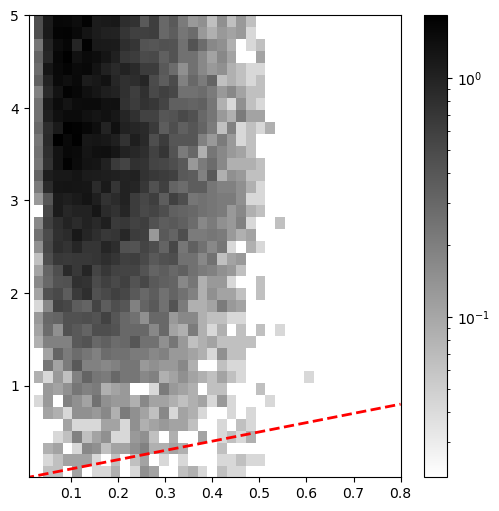

In [31]:
plt.figure(figsize=(6,6))
x = np.linspace(0,0.8,40)
y = np.linspace(0,5,40)
from matplotlib.colors import LogNorm
h2 = plt.hist2d(emds,delta_efn,bins=(x,y),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.plot(x,x,linestyle='--',color='red',linewidth=2)
plt.xlim([0.01,0.8])
plt.ylim([0.01,5])
#plt.yscale('log')
#plt.xscale('log')